In [1]:
import qnmfits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from bayes_qnm_GP_likelihood import *
from bayes_qnm_GP_likelihood.BGP_fits import BGP_fit

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from plot_config import PlotConfig

data_dir = notebook_dir.parent / "data"


In [2]:
SIMNUMS = ["0001", "0002", "0003", "0004", "0005", "0006", "0007", "0008", "0009", "0010", "0011", "0012", "0013"]
TRAINING_SPH_MODES = [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (2, -2), (2, -1), (3, -3), (3, -2), (4, -4)]

SIM_TRAINING_MODE_RULES = {
    "0001": "PE",
    "0002": "PE",
    "0003": "PE",
    "0004": "PE",
    "0005": "P",
    "0006": "P",
    "0007": "P",
    "0008": "ALL",
    "0009": "E",
    "0010": "P",
    "0011": "P",
    "0012": "P",
    "0013": "ALL",
}

TRAINING_START_TIME = -10
TRAINING_END_TIME = 100
TIME_STEP = 0.1

In [3]:
mode_filters = {
        "PE": lambda mode: mode[1] >= 0 and mode[1] % 2 == 0,
        "P": lambda mode: mode[1] >= 0,
        "E": lambda mode: mode[1] % 2 == 0,
        "ALL": lambda mode: True,
    }

analysis_times = np.arange(TRAINING_START_TIME, TRAINING_END_TIME, TIME_STEP)

In [4]:
with open(data_dir / "tuned_params_GPC.pkl", "rb") as f:
    params_GPC = pickle.load(f)

with open(data_dir / "tuned_params_GP.pkl", "rb") as f:
    params_GP = pickle.load(f)

with open(data_dir / "tuned_params_WN.pkl", "rb") as f:
    params_WN = pickle.load(f)

Processing simulation 0001 with spherical mode (2, 0)
Processing simulation 0001 with spherical mode (2, 2)
Processing simulation 0001 with spherical mode (3, 0)
Processing simulation 0001 with spherical mode (3, 2)
Processing simulation 0001 with spherical mode (4, 0)
Processing simulation 0001 with spherical mode (4, 2)
Processing simulation 0001 with spherical mode (4, 4)
Processing simulation 0001 with spherical mode (5, 0)
Processing simulation 0001 with spherical mode (5, 2)
Processing simulation 0001 with spherical mode (5, 4)
Processing simulation 0001 with spherical mode (6, 0)
Processing simulation 0001 with spherical mode (6, 2)
Processing simulation 0001 with spherical mode (6, 4)
Processing simulation 0001 with spherical mode (6, 6)
Processing simulation 0001 with spherical mode (7, 0)
Processing simulation 0001 with spherical mode (7, 2)
Processing simulation 0001 with spherical mode (7, 4)
Processing simulation 0001 with spherical mode (7, 6)
Processing simulation 0001 w

/tmp/ipykernel_391440/1821084132.py:40: RuntimeWarning: invalid value encountered in log
  ax.scatter(spherical_mode_labels, np.log(cn_list), label='Normal,Complicated', marker='s')


ValueError: x and y must be the same size

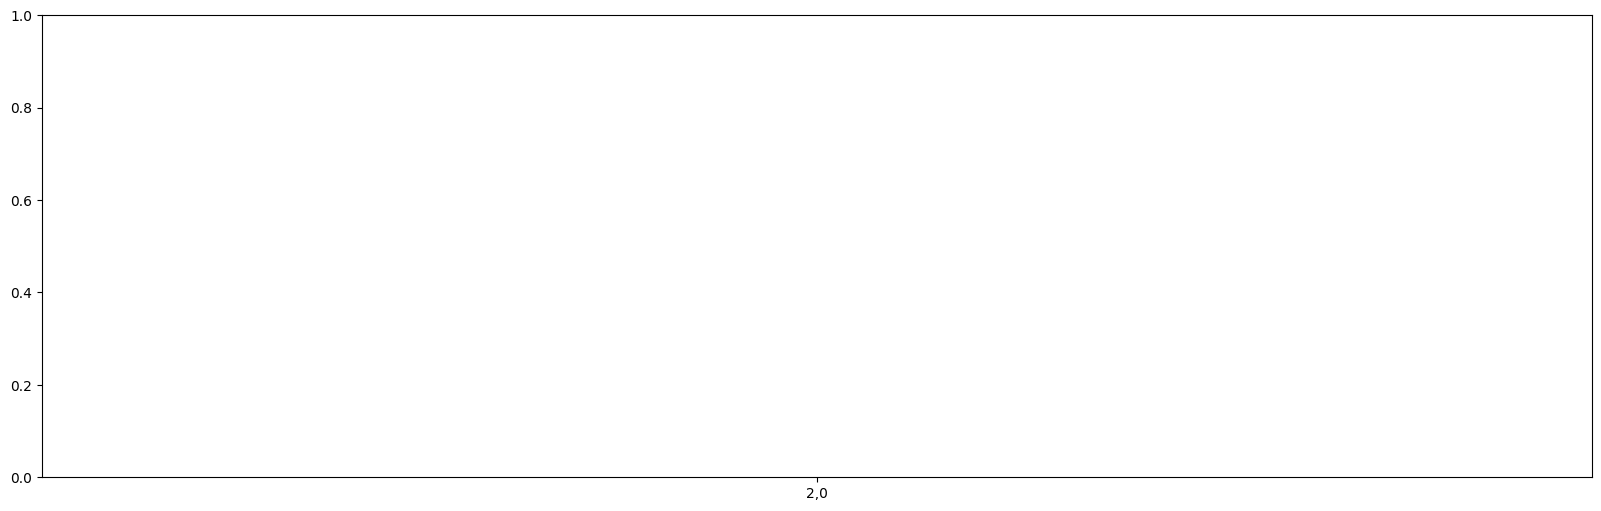

In [ ]:
sn_list_full = []
cn_list_full = []
sc_list_full = []

for sim_id, mode_rule in SIM_TRAINING_MODE_RULES.items():

    sn_list = []
    cn_list = []
    sc_list = []

    spherical_modes = params_WN[sim_id].keys()

    spherical_mode_choice = [
            mode for mode in spherical_modes if mode_filters[mode_rule](mode)
        ]

    for sph_mode in spherical_mode_choice: 

        print(f"Processing simulation {sim_id} with spherical mode {sph_mode}")

        kernel_matrix_WN = compute_kernel_matrix(analysis_times, params_WN[sim_id][sph_mode], kernel_s)
        kernel_matrix_GP = compute_kernel_matrix(analysis_times, params_GP[sim_id][sph_mode], kernel_main)
        kernel_matrix_GPC = compute_kernel_matrix(analysis_times, params_GPC[sim_id][sph_mode], kernel_c)

        kl_div_sn = js_divergence(kernel_matrix_WN, kernel_matrix_GP)
        kl_div_cn = js_divergence(kernel_matrix_GP, kernel_matrix_GPC)
        kl_div_sc = js_divergence(kernel_matrix_WN, kernel_matrix_GPC)

        sn_list.append(kl_div_sn)
        cn_list.append(kl_div_cn)
        sc_list.append(kl_div_sc)

    sn_list_full.extend(sn_list)
    cn_list_full.extend(cn_list)
    sc_list_full.extend(sc_list)

    fig, ax = plt.subplots(figsize=(20, 6))

    spherical_mode_labels = [f"{mode[0]},{mode[1]}" for mode in spherical_mode_choice]
    print(spherical_mode_labels)
    print(cn_list)
    ax.scatter(spherical_mode_labels, np.log(cn_list), label='Normal,Complicated', marker='s')
    ax.scatter(spherical_mode_labels, np.log(sc_list), label='Simple,Complicated', marker='^')
    ax.scatter(spherical_mode_labels, np.log(sn_list), label='Simple,Normal', marker='o')

    ax.set_xlabel('Spherical mode', fontsize=16)
    ax.set_ylabel('Log of JS Divergence', fontsize=16)
    ax.legend(fontsize=14)
    ax.grid(True)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)

    fig.savefig(f'outputs/JS_{sim_id}.pdf')
    plt.close(fig)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

cn_log = np.log(cn_list_full)
sc_log = np.log(sc_list_full)
sn_log = np.log(sn_list_full)

cn_log[cn_log == -np.inf] = np.nan
sc_log[sc_log == -np.inf] = np.nan
sn_log[sn_log == -np.inf] = np.nan

ax.hist(cn_log, bins=30, alpha=0.5, label='Normal,Complicated')
ax.hist(sc_log, bins=30, alpha=0.5, label='Simple,Complicated')
ax.hist(sn_log, bins=30, alpha=0.5, label='Simple,Normal')

ax.set_xlabel('Log of JS Divergence', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.legend(frameon=False, fontsize=14)
ax.grid(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#fig.savefig(f'figs/JS_histogram.pdf')